In [243]:
using LinearAlgebra

# Matrix multiplication

In [244]:
function classic_(A, B, C)
    len = size(A,1)
    for i in 1:len
       for j in 1:len
           for k in 1:len
                C[i, j] += (A[i, k] * B[k, j])
            end
        end
    end
    return C
end

classic_ (generic function with 1 method)

In [245]:
FLOPS = 0
function multiply_rec_(A, B, C)
    if size(A,1) == 2
        classic_(A, B, C)
        global FLOPS += 8
        return C
    end
    len = (size(A,1)÷2)
    a11 = [1:len,1:len]
    a12 = [1:len,len+1:len*2]
    a21 = [len+1:len*2,1:len]
    a22 = [len+1:len*2,len+1:len*2]

    multiply_rec_(
        A[a11...], 
        B[a11...],
        @view C[a11...]
    )
    multiply_rec_(
        A[a12...], 
        B[a21...],
        @view C[a11...]
    )

    multiply_rec_(
        A[a11...], 
        B[a12...],
        @view C[a12...]
    )
    multiply_rec_(
        A[a12...], 
        B[a22...],
        @view C[a12...]
    )

    multiply_rec_(
        A[a21...], 
        B[a11...],
        @view C[a21...]
    )
    multiply_rec_(
        A[a22...], 
        B[a21...],
        @view C[a21...]
    )
    
    multiply_rec_(
        A[a21...], 
        B[a12...],
        @view C[a22...]
    )
    multiply_rec_(
        A[a22...], 
        B[a22...],
        @view C[a22...]
    )
end

function multiply_rec(A, B)
    C = zeros(size(A,1), size(B,2))
    multiply_rec_(A, B, C)
    return C
end

multiply_rec (generic function with 2 methods)

In [246]:
function inv2x2(A)
    detA = A[1, 1]*A[2, 2] - A[1, 2]*A[2, 1]
    invA = [
        A[2, 2] -A[1, 2]
        -A[2, 1] A[1, 1]
    ]
    return (1/detA)*invA
end

function inv_rec(A, B)
    len = size(A,1) ÷ 2
    
    if size(A, 1) == 2
        B[:, :] = inv2x2(A)
        global FLOPS += 8
        return
    end
    
    a11 = [1:len,1:len]
    a12 = [1:len,len+1:len*2]
    a21 = [len+1:len*2,1:len]
    a22 = [len+1:len*2,len+1:len*2]

    invA11 = my_inv(A[a11...])
    
    S22 = A[a22...] - multiply_rec(
        multiply_rec(A[a21...], invA11), 
        A[a12...]
    )
        
    invS22 = my_inv(S22)
    Id = Matrix(1.0I, len, len)
    
    B[a11...] = multiply_rec(
        invA11, 
        Id + multiply_rec(
            multiply_rec(
                multiply_rec(A[a12...], invS22), 
                A[a21...]
            ), 
            invA11
        )
    )
    global FLOPS += 2 
    B[a12...] = multiply_rec(multiply_rec(-invA11, A[a12...]), invS22)
    B[a21...] = multiply_rec(multiply_rec(-invS22, A[a21...]), invA11)
    B[a22...] = invS22
end

function my_inv(A:: Matrix)
    B = 1.0 * zeros(size(A,1), size(A,1))
    inv_rec(A, B)
    return B
end

my_inv (generic function with 2 methods)

## Test if results are correct

In [247]:
function test_dot(n)
    for i in 1:n
        A = rand(2^i, 2^i)
        B = rand(2^i, 2^i)
        if isapprox(A * B, multiply_rec(A, B))
            println("Test passed for matrix of size ", 2^i, "x", 2^i)
        else
            println("Test failed for matrix of size ", 2^i, "x", 2^i)
        end
    end
end

function test_inv(n)
    for i in 1:n
        A = rand(2^i, 2^i)
        if isapprox(inv(A), my_inv(A))
            println("Test passed for matrix of size ", 2^i, "x", 2^i)
        else
            println("Test failed for matrix of size ", 2^i, "x", 2^i)
        end
    end
end

println("Testing matrix multiplication")
test_dot(5)

println("Testing inverse")
test_inv(7)

Testing matrix multiplication


Test passed for matrix of size 2x2
Test passed for matrix of size 4x4
Test passed for matrix of size 8x8
Test passed for matrix of size 16x16
Test passed for matrix of size 32x32
Testing inverse
Test passed for matrix of size 

2x2
Test passed for matrix of size 4x4
Test passed for matrix of size 8x8
Test passed for matrix of size 16x16
Test passed for matrix of size 32x32
Test passed for matrix of size 64x64
Test passed for matrix of size 

128x128


In [248]:
using Plots

function test_time_inv(n)
    times = zeros(n)
    flops = zeros(n)
    for i in 1:n
        A = rand(2^i, 2^i)
        global FLOPS = 0
        times[i] = @elapsed my_inv(A)
        flops[i] = FLOPS
        println("n=$i, time=$(times[i]), flops=$(flops[i])")
    end
    return times, flops
end

times, flops = test_time_inv(7)

n=1, time=5.459e-6, flops=8.0
n=2, time=2.55e-5, flops=98.0
n=3, time=5.8167e-5, flops=838.0
n=4, time=0.000408834, flops=6798.0
n=5, time=0.003091584, flops=54558.0
n=6, time=0.025617292, flops=436798.0


n=7, time=0.223116, flops=3.495038e6


([5.459e-6, 2.55e-5, 5.8167e-5, 0.000408834, 0.003091584, 0.025617292, 0.223116], [8.0, 98.0, 838.0, 6798.0, 54558.0, 436798.0, 3.495038e6])

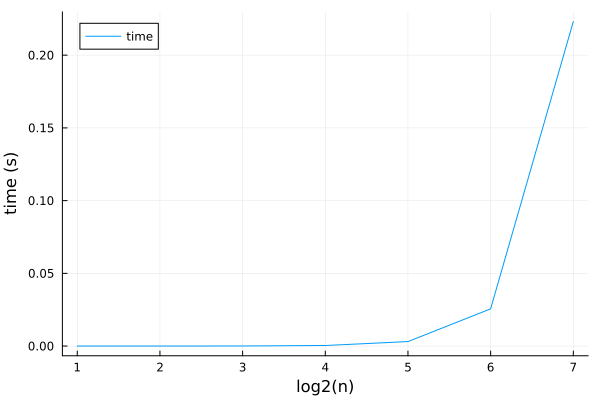

In [249]:
plot(times, label="time", xlabel="log2(n)", ylabel="time (s)")


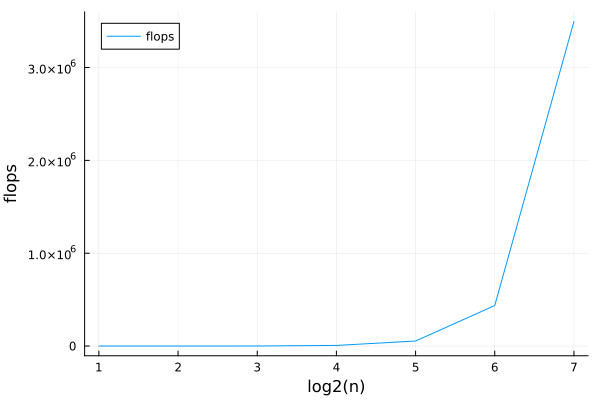

In [250]:
plot(flops, label="flops", xlabel="log2(n)", ylabel="flops")